## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import ta
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Conv1D
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams.update({'figure.figsize': (16, 9)})

## Load data

In [2]:
data = pd.read_csv('../data/processed/company_id_94_processed.csv', parse_dates=True)
data = data[['txn_date', 
             'open', 'high', 'low', 
             'close',
             'vol', 
#              'month', 
#              'day', 
#              'day_of_month'
            ]].sort_values(by='txn_date')
data['txn_date'] = pd.to_datetime(data['txn_date'])
# data = data[data['txn_date']< '2020-03-01']
data.set_index('txn_date', inplace=True, drop=True)
data['close_roc'] = data['close'].pct_change()
data['close_log_roc'] = np.log(1+data['close_roc'])
data['rsi'] = ta.momentum.RSIIndicator(close=data['close'], fillna=True).rsi()
data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
# data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
data['chaikin_money_flow'] = ta.volume.ChaikinMoneyFlowIndicator(high=data['high'], low=data['low'], close=data['close'], volume=data['vol'], fillna=True).chaikin_money_flow()
data.dropna(inplace=True)
# data = data.resample('W').mean()
data.head()

,open,high,low,close,vol,close_roc,close_log_roc,rsi,macd_signal,chaikin_money_flow
txn_date,,,,,,,,,,
1999-01-11,58.9,58.9,58.0,58.3,0.0,0.003442,0.003436,100.000000,0.003191,0.0
1999-01-12,58.6,58.7,58.4,58.5,0.0,0.003431,0.003425,100.000000,0.011398,0.0
1999-01-13,58.6,58.7,58.5,58.6,0.0,0.001709,0.001708,100.000000,0.023889,0.0
1999-01-14,58.5,59.5,58.1,58.8,0.0,0.003413,0.003407,100.000000,0.041546,0.0
1999-01-23,59.0,59.0,58.6,58.7,0.0,-0.001701,-0.001702,85.310605,0.059825,0.0


## Preprocessing

In [3]:
# data.info()

In [4]:
# data.describe()

In [5]:
# min(data.index), max(data.index), data.shape[0]

In [6]:
# data['chaikin_money_flow'].plot()
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend(['Close Price'])
# plt.show()

In [7]:
# data['close_roc'].plot()
# plt.xlabel('Date')
# plt.ylabel('Close Price Rate Of Change')
# plt.show()

In [8]:
# data['vol'].plot()
# plt.xlabel('Date')
# plt.ylabel('Trade Volume')
# plt.show()

In [9]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [110]:
def custom_ts_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [111]:
def preprocessing(x, y):
    x_scaler = MinMaxScaler(feature_range=(-1,1))
    y_scaler = MinMaxScaler(feature_range=(-1,1))
    data_x = x_scaler.fit_transform(x)
    data_y = y_scaler.fit_transform(y)
    return (x_scaler, y_scaler, data_x, data_y)

In [127]:
def split_data(window, data_x, data_y, size=0.8, horizon=5):
    TRAIN_SPLIT = int(len(data_x)*size)
    x_train_multi, y_train_multi = custom_ts_data_prep(data_x, data_y, 0, TRAIN_SPLIT, window, horizon)
    x_val_multi, y_val_multi= custom_ts_data_prep(data_x, data_y, TRAIN_SPLIT, None, window, horizon)
    split = int(len(x_val_multi)*0.5)
#     x_val_multi, y_val_multi, x_test_multi, y_test_multi = x_val_multi[: split], y_val_multi[:split], x_val_multi[:-split], y_val_multi[:-split]
    assert(x_train_multi.shape[0]  == y_train_multi.shape[0])
    assert(x_val_multi.shape[0]  == y_val_multi.shape[0])
    return x_train_multi, y_train_multi, x_val_multi[: split], y_val_multi[:split], x_val_multi[:-split], y_val_multi[:-split],split

In [143]:
def prep_data(train_data, val_data):
    BATCH_SIZE = 128
    BUFFER_SIZE = 150
#     print(train_data[0].shape, val_data[0].shape)
#     print(train_data[1].shape, val_data[1].shape)
    train_data = tf.data.Dataset.from_tensor_slices(train_data)
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data = tf.data.Dataset.from_tensor_slices(val_data)
    val_data = val_data.batch(BATCH_SIZE).repeat()
    return (train_data, val_data)

In [114]:
def show_model_loss_plot(history, title=''):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss ' + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
#     plt.rcParams["figure.figsize"] = [16,9]
    plt.show()

In [124]:
def process(scaler, y_val_multi, 
            y_test_multi, 
            result_inv_trans,
            data, split,into=0):
    a = pd.DataFrame([scaler.inverse_transform(y[0].reshape(-1,1))[0][0] 
                      for y in y_val_multi], index=np.array(data.index)[-2*split:-split])
    b = pd.DataFrame([scaler.inverse_transform(y[0].reshape(-1,1))[0][0] 
                      for y in y_test_multi], index=data[-len(y_test_multi):].index)
    c = pd.DataFrame([scaler.inverse_transform(np.array(y[into]).reshape(-1,1))[0][0] 
                      for y in result_inv_trans], index=data[-len(result_inv_trans):].index)
    return a, b, c

In [116]:
def show_actual_vs_predicted_plot(a, b, c, title=''):    
    plt.plot(a )
    plt.plot(b)
    plt.plot(c)
    plt.title("Actual vs Predicted " + title)
    plt.ylabel("Price Rate of Change")
    plt.legend(('val','Actual','predicted'))
    plt.show()

In [146]:
def train_model(model, train_data, val_data, model_path,
                epochs=100, steps_per_epoch=100,
               validation_steps=50, verbose=1, callbacks= None):
    if callbacks == None:
        callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, patience=5,
                                                     verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',
                                                                  save_best_only=True, 
                                                                  mode='min',
                                                                  verbose=0)]
    
    history = model.fit(train_data, epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps, verbose =verbose,
                        callbacks=callbacks)
    return history

In [150]:
def lifecycle(data, model_type='lstm', window=22, output='close', horizon=1, into=0):
    x_scaler, y_scaler,data_x, data_y = preprocessing(data, data[[output]])
    x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_test_multi, y_test_multi, split = split_data(window, data_x, data_y, 0.7, horizon=horizon)
    train_data, val_data = prep_data((x_train_multi, y_train_multi), (x_val_multi, y_val_multi))
    model = get_model(model_type, x_train_multi.shape[-2:], output=horizon)
    model_path = r'../models/LSTM_Multivariate.h5'
    history = train_model(model, train_data, val_data, model_path)
    model = tf.keras.models.load_model(model_path)
    model.summary()
    result_inv_trans = model.predict(x_test_multi)
    print(result_inv_trans[0], y_val_multi[0])
    a, b, c = process(y_scaler, y_val_multi, y_test_multi, result_inv_trans, data, split, into=into)
    timeseries_evaluation_metrics_func(b.values, c.values)
    title = '{} for {} Days'.format(model_type.upper(), window)
#     show_model_loss_plot(history, title)
    show_actual_vs_predicted_plot(a, b, c, title)

In [151]:
def get_model(type, input_shape, optimizer='adam', loss='mse', output=1):
    model = None
    if type == 'lstm':
        model = Sequential([
            LSTM(40, input_shape=input_shape, return_sequences=True),
            LSTM(units=40,return_sequences=True),
            Dropout(0.1),
            LSTM(units=40,return_sequences=True),
            Dropout(0.1),
            LSTM(units=20),
            Dense(units=output)
        ])
    elif type == 'rnn':
            model = Sequential([
                SimpleRNN(50, input_shape=input_shape, return_sequences=True),
                Dropout(0.1),
                SimpleRNN(15, input_shape=input_shape, return_sequences=True),
                Dropout(0.1),
#                 SimpleRNN(50, input_shape=input_shape, return_sequences=True),
                Dense(output)
            ])
    elif type == 'gru':
        model = Sequential([
            GRU(50, input_shape=input_shape, return_sequences=True),
            Dropout(0.1),
            Dense(output)
        ])
    else:
        None
    model.compile(optimizer=optimizer, loss=loss)
    return model

(3765, 5, 10) (805, 5, 10)
(3765, 1, 1) (805, 1, 1)
Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 0.1654
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0558
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0411
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0260
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0192
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0171
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0149
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0133
Epoch 9/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0120
Epoch 10/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0109
Epoch 11/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0103
Epoch 12/100
100/100 [======================

100/100 [==============================] - 1s 6ms/step - loss: 0.0071
Epoch 25/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 26/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0068
Epoch 27/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0068
Epoch 28/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0064
Epoch 29/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 30/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 31/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 32/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0067
Epoch 33/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 34/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 35/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0057
Epoch 36/100
100/

100/100 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 49/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0061
Epoch 50/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 51/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 52/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 53/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 54/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 55/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 56/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 57/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0061
Epoch 58/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 59/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 60/100
100/

100/100 [==============================] - 1s 6ms/step - loss: 0.0064
Epoch 73/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 74/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 75/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0066
Epoch 76/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 77/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 78/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 79/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 80/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 81/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0066
Epoch 82/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 83/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 84/100
100/

100/100 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 97/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 98/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0065
Epoch 99/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0077
Epoch 100/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0065
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 22, 40)            8160      
_________________________________________________________________
lstm_53 (LSTM)               (None, 22, 40)            12960     
_________________________________________________________________
dropout_51 (Dropout)         (None, 22, 40)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 22, 40)   

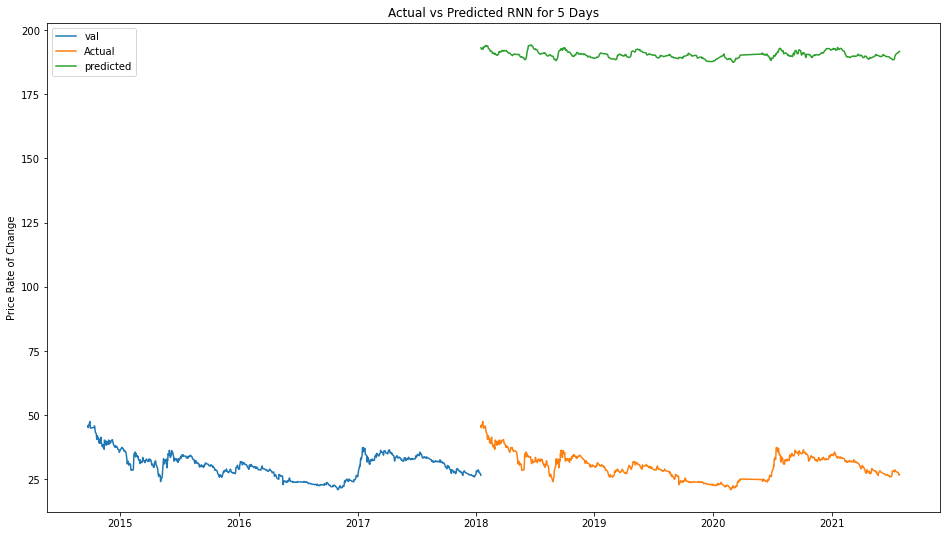

In [152]:
# lstm_model.compile(optimizer='adam', loss='mse')
lifecycle(data, 'rnn', 5)